# Sandbox for Testing Motion Correction of Live Imaging Data

In [23]:
# base and metaprogramming imports
from __future__ import annotations

import datetime
import time
import os
import shutil
import sys
import itertools as it
import pprint as pp
from typing import Optional
import warnings
import glob
import copy

# analysis imports
import h5py
import numpy as np
import pandas as pd
import pandas
import yaml
from pandas.api.types import CategoricalDtype
import scipy
import scipy.ndimage
import skimage as ski
from tifffile.tifffile import imwrite
import pickle

import ants
try:
    ants.from_numpy
except Exception:
    warnings.warn(f'`ants` module import failed.')
    ants = None
else:
    print('`ants` installed and imported successfully.')

# visualization imports
import napari
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

import seaborn as sns

# ipynb-specific imports
try:
    import ipynbname
except Exception as e:
    warnings.warn(f'`ipynbname` module import failed with error: {e!r}')
    ipynbname = None
    
if ipynbname is not None:
    #_file = ipynbname.path()
    _file = 'C:\\Users\\AndyPhung\\Documents\\ZMIA-Zebrafish-Multimodal-Image-Analysis\\source\\jobs\\local-nb_cs-ii-[29,33,34]_caiman-motion-correct-sandbox.ipynb'
else:
    # manually set the full path to the current notebook below if `ipynbname` 
    # import fails
    # raise ImportError('`ipynbname` import failed. '
    #                   'Please set the `_file` variable manually then'
    #                   'comment out this error.')
    _file = 'C:\\Users\\AndyPhung\\Documents\\ZMIA-Zebrafish-Multimodal-Image-Analysis\\source\\jobs\\local-nb_cs-ii-[29,33,34]_caiman-motion-correct-sandbox.ipynb'
    
jobs_dir = os.path.split(_file)[0]
sources_dir = os.path.abspath(os.path.join(jobs_dir, '..'))
repo_dir = os.path.abspath(os.path.join(sources_dir, '..'))
config_dir = os.path.abspath(os.path.join(repo_dir, 'configs'))
default_data_dir = os.path.abspath(os.path.join(repo_dir, 'data'))

# add sources directory to path
if sources_dir not in sys.path:
    sys.path.append(sources_dir)

# local imports
import c_swain_python_utils as csutils
from utilities import *
import imaging_dataset as imd
import prairie_view_imports as pvi

# caiman imports
import bokeh.plotting as bpl
import cv2
try:
    cv2.setNumThreads(0)
except Exception:
    pass
import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
bpl.output_notebook()


_basename = os.path.basename(_file)
_name = csutils.no_ext_basename(_file)

`ants` installed and imported successfully.


Loading BokehJS ...

## Setup
### Plotting Defaults

In [24]:
mpl.font_manager.fontManager.addfont('C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-Black.otf')
mpl.font_manager.fontManager.addfont('C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-Bold.otf')
mpl.font_manager.fontManager.addfont('C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-Roman.otf')
sns.set_style(
    'ticks',
    {'font.sans-serif': ['Helvetica LT Pro', ],
     'mathtext.fontset': ['cm',],
     'axes.linewidth': 2,
     }
)
axes_lw = 2
mpl.rcParams['axes.linewidth'] = axes_lw
mpl.rcParams['xtick.major.width'] = axes_lw
mpl.rcParams['xtick.minor.width'] = axes_lw
mpl.rcParams['ytick.major.width'] = axes_lw
mpl.rcParams['ytick.minor.width'] = axes_lw

### Logging Setup

In [25]:
# logging setup
log = csutils.get_logger(_name)

debug_mode = False
default_window_level = 'debug'

log_path = os.path.join(sources_dir, '..', 'logs', f'{_basename}.log')
csutils.apply_standard_logging_config(
    file_path=log_path,
    window_level='debug' if debug_mode else default_window_level,
    window_format='debug' if debug_mode else 'default')

### Data Directory Setup

In [26]:
# data_dir = default_data_dir # may need to set this manually
data_dir = r'E:\andyphung\zf_correlative_microscopy'
if not os.path.exists(data_dir):
    raise RuntimeError(f'Data directory `{data_dir = }` does not exist.')

sandbox_dir = os.path.join(
    data_dir, 
    'analyzed_and_generated_data',
    'motion-correction-sandbox')
csutils.touchdir(sandbox_dir)

log.info(f'Sandbox directory: "{sandbox_dir}" successfully set.')

local-nb_cs-ii-[29,33,34]_caiman-motion-correct-sandbox (  12): INFO : Sandbox directory: "E:\andyphung\zf_correlative_microscopy\analyzed_and_generated_data\motion-correction-sandbox" successfully set.


## Load Configurations

In [27]:
config_fname_list = [
    'cs-ii-29_config.yml',
    'cs-ii-33_config.yml',
    'cs-ii-34_config.yml']

config_fname_list = config_fname_list[0:1]  # subset for testing

multi_experiment_output_dir = os.path.join(
    sandbox_dir,
    'outputs')
csutils.touchdir(multi_experiment_output_dir)

# subsetted for testing
# TODO - remove this line
# config_fname_list = config_fname_list[0:1]

config_list: list[ZMIAConfig] = []
for config_fname in config_fname_list:
    config_list.append(
        ZMIAConfig(os.path.join(config_dir, config_fname))) 

all_dataset_infos = sum([c.dataset_list for c in config_list], [])

all_2p_live_dataset_infos = [
    di for di in all_dataset_infos                    
    if (di.type == 'two-photon' and di.run_id is not None)]

all_2p_live_dataset_infos = all_2p_live_dataset_infos[0:1] # subset for testing

num_matched_datasets = len(all_2p_live_dataset_infos)
log.info('Matched {:d} live 2p dataset(s).', num_matched_datasets)

utilities ( 391): WARNING : {'fish-genotype': 'nacre, HuC:H2B-GCaMP8s', 'experiment-id': 'cs-ii-29', 'datetime-stamp': '20230803-1407', 'name': 'fish-29B_stitched-gcamp-stain', 'experiment': 'cs-ii-29', 'datetime': '20230825-1000', 'fish-id': 'B', 'type': 'confocal', 'path': 'cs-ii-29_confocal_20230825\\fish-B\\STITCH_fish-B_high-res-stack_6-pos_460-z_1-chan_021_v3.tif', 'xy-pitch-um': 0.17097, 'z-pitch-um': 1.0, 'notes': "- fixed tissue processing pipeline:\n- imaging settings:\n  - 1 um z-spacing\n  - 5.849 pixels per micron in x-y\n  - Nikon 40X LWD objective      \n  - imaged over 6 positions\n- processing:\n  - image stacks stitched with ImageJ's pairwise stitching plugin\n"} s full path does not exist.
	"E:\andyphung\zf_correlative_microscopy\raw_data\cs-ii-29_confocal_20230825\fish-B\STITCH_fish-B_high-res-stack_6-pos_460-z_1-chan_021_v3.tif"
utilities ( 391): WARNING : {'fish-genotype': 'nacre, HuC:H2B-GCaMP8s', 'experiment-id': 'cs-ii-29', 'datetime-stamp': '20230803-1407', 'n

local-nb_cs-ii-[29,33,34]_caiman-motion-correct-sandbox (  31): INFO : Matched 1 live 2p dataset(s).


In [28]:
# store some additional metadata by full path
dsi: ZMIADatasetInfo
misc_metadata_dict: dict[str, dict] = {}
for dsi in all_2p_live_dataset_infos:
    misc_metadata_dict[dsi.full_path] = {
        'dataset_info': dsi,
        'experiment_id': dsi.data['experiment-id'],
        'run_id': dsi.run_id
    }
    
misc_metadata_dict

{'E:\\andyphung\\zf_correlative_microscopy\\raw_data\\cs-ii-29_2-photon_20230802\\fish-B\\TSeries-08032023-1407-395': {'dataset_info': {'fish-genotype': 'nacre, HuC:H2B-GCaMP8s', 'experiment-id': 'cs-ii-29', 'datetime-stamp': '20230803-1407', 'name': 'fish-29B_run-395_2p-tz', 'experiment': 'cs-ii-29', 'datetime': '20230803-1407', 'fish-id': 'B', 'run': 395, 'run-id': 395, 'type': 'two-photon', 'path': 'cs-ii-29_2-photon_20230802\\fish-B\\TSeries-08032023-1407-395', 'z-index-to-ignore': [0, 1], 'notes': '- z series settings: \n  - 40 planes\n  - unidirectional scan\n  - 1 ms wait\n  - frame period is approx 0.99 seconds\n  - 855 reps for       \t\n- 850 second recording\n- 16X Nikon Objective\n- fish is HuC:H2B-GCaMP8s\n  - brightness rating of 4 / 5\n'},
  'experiment_id': 'cs-ii-29',
  'run_id': 395}}

## Load Live Imaging Datasets

In [ ]:
# RESET TO FALSE TO PREVENT EXPENSIVE RELOADING OF IMAGING DATASETS
force_image_data_dict_creation = False  # <<<<<<<<<<<<< FALSE <<<<<

if 'imaging_dataset_dict' in locals() and not force_image_data_dict_creation:
    log.warning('`imaging_dataset_dict` already exists. Skipping creation...')
else:
    imaging_dataset_dict = {}

In [ ]:
for i, dsi in enumerate(all_2p_live_dataset_infos):
    full_path = dsi.full_path
    if full_path in imaging_dataset_dict:
        log.warning(
            'Dataset {:d} of {:d} already loaded into dict:\n\t"{:s}".'
            '\n\tSkipping...',
            i + 1, num_matched_datasets, full_path)
        continue
    
    log.info('Loading dataset {:d} of {:d}:\n\t"{:s}".',
             i + 1, num_matched_datasets, full_path)
    
    try:
        live_imds = imd.ImagingDataset.from_dataset_info(dsi)
    except Exception as e:
        log.error(
            'Failed to load dataset:\n\t"{:s}".',
            full_path, exc_info=e)
        continue
    else:
        imaging_dataset_dict[full_path] = live_imds

### Imaging Data Pre-Processing

In [ ]:
proc_imds: dict[str, dict[str, imd.ImagingDataset]]
if 'proc_imds' in locals() and isinstance(proc_imds, dict):
    log.warning('`proc_imds` already exists. Skipping creation...')
else:
    proc_imds = {}

DROP_SLICES_KEY = 'drop_slices'
force_drop_slices = False  # <<<<<<<<<<<<< FALSE <<<<<
MAX_TIME_PROJECTION_KEY = 'max_time_projection'
force_max_time_projection = False  # <<<<<<<<<<<<< FALSE <<<<<

imds: imd.ImagingDataset
for full_path, imds in imaging_dataset_dict.items():
    dsi = misc_metadata_dict[full_path]['dataset_info']
    experiment_id = misc_metadata_dict[full_path]['experiment_id']
    run_id = misc_metadata_dict[full_path]['run_id']
    
    log.info(f'Performing operations on the following dataset:'
             f'\n\t{imds.name}\n\tshape={imds.shape_dict}')
    
    if full_path not in proc_imds:
        proc_imds[full_path] = dict()
    
    if DROP_SLICES_KEY in proc_imds[full_path] and not force_drop_slices:
        log.warning(
            '> Dataset "{:s}" already has a drop_slices entry. Skipping...',
            dsi.name)
    else:        
        is_bidirectional = imds.source_data.metadata[pvi.pvmk.BIDIRECTIONAL_Z_SCAN]
        if not is_bidirectional:
            log.info('> Dropping frames from mono-directional acquisition in dataset',
                 dsi.name)
            imds = imds.drop_slices(slice_indexes=[0, 1], axis=imd.Dim.Z)
            
        proc_imds[full_path][DROP_SLICES_KEY] = imds    
    
    if MAX_TIME_PROJECTION_KEY in proc_imds[full_path] and not force_max_time_projection:
        log.warning(
            '> Dataset "{:s}" already has a max_time_projection entry. Skipping...',
            dsi.name)
    else:
        log.info('> Taking max projection of dataset "{}"',
                 dsi.name)        
        max_imds = imds.apply(np.max, axis=imd.Dim.TIME)
        proc_imds[full_path][MAX_TIME_PROJECTION_KEY] = max_imds  

### Quick Preview of Image Projections

In [ ]:
# function for production a quick projection preview
def vol_projection_fig(image_dataset: imd.ImagingDataset, 
                       title, 
                       proj_fcn=np.sum, 
                       proj_fcn_name='Sum'):
    
    xy_proj = image_dataset.apply(proj_fcn, axis=imd.Dim.Z)
    xz_proj = image_dataset.apply(proj_fcn, axis=imd.Dim.Y)
    yz_proj = image_dataset.apply(proj_fcn, axis=imd.Dim.X)
    
    z_vec = image_dataset.coordinates[imd.Dim.Z].vector
    y_vec = image_dataset.coordinates[imd.Dim.Y].vector
    x_vec = image_dataset.coordinates[imd.Dim.X].vector
    
    z_lim = (z_vec.min(), z_vec.max())
    y_lim = (y_vec.min(), y_vec.max())
    x_lim = (x_vec.min(), x_vec.max())
        
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(6,10))

    ax1.imshow(xy_proj.get_image_data(), extent=[*x_lim, *y_lim])
    ax1.set_title(f'{title}\nXY {proj_fcn_name} Projection')
    
    ax2.imshow(xz_proj.get_image_data(), extent=[*x_lim, *z_lim])
    ax2.set_title(f'XZ {proj_fcn_name} Projection')
    
    ax3.imshow(yz_proj.get_image_data(), extent=[*y_lim, *z_lim])
    ax3.set_title(f'YZ {proj_fcn_name} Projection')
    
    plt.tight_layout()
    plt.show()        
    
    return fig

In [ ]:
def pretty_vol_projection_fig(
        image_data: np.ndarray,
        xyz_axes: tuple[int, int, int],
        xlim: tuple[float, float],
        ylim: tuple[float, float],
        zlim: tuple[float, float],
        proj_fcn: callable = np.sum,
        title: str = None,
        fig_height: int = 5,
        subplot_space: float = 0.02,
        **kwargs) -> plt.Figure:
    
    xsize, ysize, zsize = tuple(
        np.abs(np.diff(lim)).item() 
        for lim in (xlim, ylim, zlim))
    
    yz_proj, xz_proj, xy_proj = tuple(
        proj_fcn(image_data, axis=axis) for axis in xyz_axes)
    yz_proj = np.rot90(yz_proj, k=-1)
            
    avg_width = np.mean([xsize, zsize])
    avg_height = np.mean([ysize, zsize])
    
    bottom = 0.01
    top = 0.99
    left = 0.01
    right = 0.99
    
    wspace = subplot_space
    wspace_size = avg_width * wspace
    hspace_size = wspace_size
    hspace = hspace_size / avg_height 
    log.info(f'{hspace = }')    
    
    rel_fig_width = (
        (xsize + wspace_size + zsize)
        / (right - left))
    rel_fig_height = (
        (ysize + hspace_size + zsize)
        / (top - bottom))    
    aspect_ratio = rel_fig_width / rel_fig_height        
    fig_width = fig_height * aspect_ratio    
    
    fig, axs = plt.subplots(
        2, 2,
        figsize=(fig_width, fig_height),
        width_ratios=[xsize, zsize],
        height_ratios=[ysize, zsize],
        gridspec_kw=dict(
            bottom=bottom,
            top=top,            
            left=left,
            right=right,
            wspace=wspace,
            hspace=hspace,
        ),
    )
    
    ax_xy = axs[0, 0]
    ax_xz = axs[1, 0]
    ax_yz = axs[0, 1]
    ax_3d = axs[1, 1]
    
    ax_xy.imshow(xy_proj, extent=[*xlim, *ylim], **kwargs)
    ax_yz.imshow(yz_proj, extent=[*zlim, *ylim], **kwargs)
    ax_xz.imshow(xz_proj, extent=[*xlim, *zlim], **kwargs)
    
    scalebar = AnchoredSizeBar(
        ax_xy.transData,
        200, 
        '200 $\mathdefault{{\mu}m}$',
        'lower right', 
        pad=0.4,
        color='white',
        frameon=False,
        size_vertical=10,
        fontproperties={'weight': 'bold'})
    
    ax_xy.add_artist(scalebar)
    
    ax_xy.sharex(ax_xz)
    ax_xy.sharey(ax_yz)
    ax_yz.invert_xaxis()
    
    for ax in axs.flat:
        ax.set_xticks([])
        ax.set_yticks([])
        sns.despine(
            ax=ax, left=True, right=True, top=True, bottom=True)    
    
    return fig
    
%matplotlib qt

for proc_dict in proc_imds.values():
    log.info('Displaying max projection for dataset')
    drop_imds = proc_dict[DROP_SLICES_KEY]
    raw_im_data = drop_imds.get_image_data()
    
    if 'raw_im_data_std' in proc_dict:
        raw_im_data_std = proc_dict['raw_im_data_std']
    else:
        log.info('Computing standard deviation of raw image data across time...')
        raw_im_data_std = np.std(raw_im_data, axis=0)
        proc_dict['raw_im_data_std'] = raw_im_data_std
        log.info(f'Done. {raw_im_data_std.shape = }')
        
    max_imds = proc_dict[MAX_TIME_PROJECTION_KEY]
    log.info(f'{max_imds.name = }')
    xyz_axes = tuple(
        max_imds.axis_dict[d] 
        for d in (imd.Dim.X, imd.Dim.Y, imd.Dim.Z))
    coordd = max_imds.coordinates
    xlim, ylim, zlim = tuple(
        (coordd[d].vector.min(), coordd[d].vector.max())
        for d in (imd.Dim.X, imd.Dim.Y, imd.Dim.Z))
    
    log.info(f'{xyz_axes = }')
    log.info(f'{xlim = }')
    log.info(f'{ylim = }')
    log.info(f'{zlim = }')
    log.info('Running pretty_vol_projection_fig...')
    fig = pretty_vol_projection_fig(
        image_data=raw_im_data_std,
        xyz_axes=xyz_axes,
        xlim=xlim,
        ylim=ylim,
        zlim=zlim,
        proj_fcn=np.max,
        fig_height=6,
        cmap='cividis')
    plt.show()
    log.info('Done.')
    

In [ ]:
%matplotlib qt
# quick preview of max projections for each dataset
for full_path, imds_dict in proc_imds.items():
    dsi = misc_metadata_dict[full_path]['dataset_info']
    tag = f'{dsi.data["experiment-id"]}, run-{dsi.run_id}'
    max_imds = imds_dict[MAX_TIME_PROJECTION_KEY]
    
    fig = vol_projection_fig(max_imds, tag)
    
    fig_dir = os.path.join(multi_experiment_output_dir, 'figures')
    csutils.touchdir(fig_dir)
    
    fname_str = (
        f'{dsi.data["experiment-id"]}_'
        f'run-{dsi.run_id}_'
        f'live-2p-time-max-projection-preview')
    output_path = os.path.join(
        fig_dir, f'{fname_str}.png')
    
    log.info(f'Saving figure {tag} to \n\t"{output_path}".')
    fig.savefig(output_path, dpi=300)

## Filter Out Bad Experiments

In [ ]:
drop_experiments = [
    ('cs-ii-34', 207),]
do_rotate_atlas_experiments = [
    ('cs-ii-34', 208),
    ('cs-ii-34', 209)]

## Loading Z-Brain Atlas Data

In [ ]:
log.info('Loading Atlas Config...')
ref_config = ZMIAConfig(os.path.join(config_dir, 'no-nb-ref_config_z-brain-atlas.yml'))
log.info('Loading Atlas Dataset...')
ref_ds = imd.ImagingDataset.from_dataset_info(ref_config.get_dataset_info(name='h2b-rfp-brain'))
log.info('Flipping Z direction for atlas')
ref_ds_prime = ref_ds.flip(axis=Dim.Z)

In [ ]:
ref_ds_prime.scale

### Previewing Atlas Data

In [ ]:
%matplotlib qt
fig = vol_projection_fig(ref_ds_prime, 'z-brain-atlas_z-flip')

fig_dir = os.path.join(multi_experiment_output_dir, 'figures')
csutils.touchdir(fig_dir)

fname_str = (
    f'REF_z-brain-atlas_z-flip_'
    f'preview')
output_path = os.path.join(fig_dir, f'{fname_str}.png')

log.info(f'Saving figure "z-brain-atlas_z-flip" to \n\t"{output_path}".')
fig.savefig(output_path, dpi=300)

## Performing Live to Atlas Registration
### Registration Helper Functions

In [ ]:
def resize(image: np.ndarray, 
           new_shape: tuple[int, ...] | np.ndarray,
           **kwargs) -> np.ndarray:
    current_shape = np.array(image.shape)
    shape_delta = np.round(new_shape) - current_shape
    if np.all(np.abs(shape_delta) < 0.5):
        return image
    downsize: bool = np.any(shape_delta < 0)
    anti_alias = kwargs.pop('anti_aliasing', downsize)
    return ski.transform.resize(image,
                                output_shape=np.round(new_shape),
                                anti_aliasing=anti_alias,
                                **kwargs)

In [ ]:
@csutils.timed(log)
def register(fixed: np.ndarray, 
             moving: np.ndarray,
             ) -> tuple[np.ndarray, dict]:
    fixed_ants = ants.from_numpy(fixed)
    # TODO - look into setting `spacing` parameter in the conversion
    moving_ants = ants.from_numpy(moving)
    
    # TODO - for a few datasets run a jobs many different compinations of parameters
    #        try type_of_transform=`SyNAggro`
    
    log.info('> > Calculating Registration Transform')
    transform = ants.registration(
        fixed=fixed_ants,
        moving=moving_ants,
        type_of_transform='SyN',
        syn_metric='demons',
        # syn_sampling=16,
        verbose=True)    
    
    return transform

In [ ]:
FORWARD_TRANSFORMS_KEY = 'fwdtransforms'
REVERSE_TRANSFORMS_KEY = 'invtransforms'

def save_transforms(transform: dict, 
                    output_path: str,
                    ) -> None:
    
    output_name = csutils.no_ext_basename(output_path)
    cache_dir = os.path.join(
        os.path.split(output_path)[0],
        '.pycaches')
    csutils.touchdir(cache_dir)
    
    new_transform_dict = dict()
    
    for key in [FORWARD_TRANSFORMS_KEY, REVERSE_TRANSFORMS_KEY]:
        new_transform_dict[key] = []
        for value in transform[key]:
            tform_fname = os.path.basename(value)
            new_tform_path = os.path.join(cache_dir, f'{output_name}_{tform_fname}')
            if not os.path.exists(new_tform_path):                
                log.debug(f'Copying transform file'
                          f'\n\tFROM: "{value}"'
                          f'\n\tTO:   "{new_tform_path}".')
                shutil.copy(value, new_tform_path)
            new_transform_dict[key].append(new_tform_path)
    
    log.info(f'> > Saving new transform dict at\n\t"{output_path}".')
    csutils.save_to_disk(new_transform_dict, output_path)
    
def load_transforms(
        transform_path: str | os.PathLike | bytes,
        ) -> dict[str, list[str]]:
    
    transform: dict[str, list[str]] = csutils.load_from_disk(transform_path)  
    
    for k, v in transform.items():
        for i, tform_path in enumerate(v):        
            tform_path_fname = os.path.split(tform_path)[1]
            old_name_idx = tform_path_fname.find('_tmp')
            old_name = tform_path_fname[(old_name_idx + 1):]
            
            old_path = os.path.join(os.environ['TEMP'], old_name)
            
            if not os.path.exists(old_path):
                log.debug('> Transform file "{}" does not exist in temp directory, copying back.',
                          old_name)
                shutil.copy(tform_path, old_path) 
            transform[k][i] = old_path
    return transform

### Compute Registration Transformations

In [ ]:
output_tform_path_fmt = os.path.join(
    multi_experiment_output_dir, 
    'transforms',
    '{experiment_id}_run-{run_id}_live-to-atlas-tform_v{reg_version}.pkl')

In [ ]:
force_image_registration = False  # <<<<<<<<<<<<< FALSE <<<<<

MOVING_RESCALE_FACTOR_KEY = 'moving_rescale_factor'
FIXED_RESCALE_FACTOR_KEY = 'fixed_rescale_factor'
MIN_SCALE_KEY = 'min_scale'
MOVING_IMDS_ID_KEY = 'moving_imds_id'
FIXED_IMDS_ID_KEY = 'fixed_imds_id'
REG_TRANSFORM_PATH_KEY = 'reg_transform_path'
MOVING_NEW_SHAPE_KEY = 'moving_new_shape'
FIXED_NEW_SHAPE_KEY = 'fixed_new_shape'

# TODO - update upon any changes to registration process
reg_version = 2

for full_path, imds_dict in proc_imds.items():
    dsi = misc_metadata_dict[full_path]['dataset_info']
    tag = f'{dsi.data["experiment-id"]}, run-{dsi.run_id}'
    max_imds = imds_dict[MAX_TIME_PROJECTION_KEY]
    
    log.info(f'Performing registration for dataset {tag}.')
    
    if (dsi.data['experiment-id'], dsi.run_id) in drop_experiments:
        log.info(f'> Dropping dataset {tag} from analysis.')
        continue        
    
    if (dsi.data['experiment-id'], dsi.run_id) in do_rotate_atlas_experiments:
        log.info(f'> Rotating atlas for alignment to dataset {tag}.')
        ref_ds_prime_rot = ref_ds_prime.rot90(axis=Dim.Z, k=2)         
    else:
        ref_ds_prime_rot = ref_ds_prime
    
    moving_imds = max_imds
    fixed_imds = ref_ds_prime_rot
    
    misc_metadata_dict[full_path][MOVING_IMDS_ID_KEY] = f'live 2p, {tag}'
    misc_metadata_dict[full_path][FIXED_IMDS_ID_KEY] = 'z-brain-atlas'
    
    log.info('> Calculating Rescale Factors and New Shapes')
    moving_scale = np.abs(moving_imds.scale)
    # log.info(f'{moving_scale = }')
    moving_im_raw = moving_imds.get_image_data()
    
    fixed_scale = np.abs(fixed_imds.scale)
    # log.info(f'{fixed_scale = }')
    fixed_im_raw = fixed_imds.get_image_data()
    
    min_scale = np.min([moving_scale, fixed_scale], axis=0)
    # log.info(f'{min_scale = }')
    
    moving_rescale_factor = moving_scale / min_scale
    fixed_rescale_factor = fixed_scale / min_scale
    # log.info(f'{moving_rescale_factor = }')
    # log.info(f'{fixed_rescale_factor = }')
    
    moving_new_shape = np.round(np.array(moving_imds.shape) * moving_rescale_factor)
    fixed_new_shape = np.round(np.array(fixed_imds.shape) * fixed_rescale_factor)
    # log.info(f'{moving_imds.shape = }')
    # log.info(f'{moving_new_shape = }')
    # log.info(f'{fixed_imds.shape = }')
    # log.info(f'{fixed_new_shape = }')
    
    misc_metadata_dict[full_path][MOVING_RESCALE_FACTOR_KEY] = moving_rescale_factor
    misc_metadata_dict[full_path][FIXED_RESCALE_FACTOR_KEY] = fixed_rescale_factor
    misc_metadata_dict[full_path][MOVING_NEW_SHAPE_KEY] = moving_new_shape
    misc_metadata_dict[full_path][FIXED_NEW_SHAPE_KEY] = fixed_new_shape
    misc_metadata_dict[full_path][MIN_SCALE_KEY] = min_scale
    
    # TODO - skipping histogram matching for now, might need to perform it based on results
    
    moving_im_clip = moving_im_raw
    fixed_im_clip = fixed_im_raw
    
    moving_im_float = moving_im_clip.astype(float)
    moving_im_float = moving_im_float - moving_im_float.min()
    moving_im_float = moving_im_float / moving_im_float.max()
    
    fixed_im_float = fixed_im_clip.astype(float)
    fixed_im_float = fixed_im_float - fixed_im_float.min()
    fixed_im_float = fixed_im_float / fixed_im_float.max()

    log.info('> Resizing Images')
    moving_im_resize = resize(moving_im_float, 
                              new_shape=moving_new_shape)
    fixed_im_resize = resize(fixed_im_float, 
                             new_shape=fixed_new_shape)
    
    log.info('> Applying Gaussian Filter')
    sigma_kernel_um = np.array([2, 1, 1], dtype=float)
    sigma_kernel = np.ceil(sigma_kernel_um / min_scale) 
    
    moving_im_filt = ski.filters.gaussian(moving_im_resize, 
                                          sigma=sigma_kernel)
    fixed_im_filt = ski.filters.gaussian(fixed_im_float, 
                                         sigma=sigma_kernel)
    
    moving_im_pre_reg = moving_im_filt
    fixed_im_reg = fixed_im_filt
    
    save_path = output_tform_path_fmt.format(
        **dict(experiment_id=dsi.data['experiment-id'], 
               run_id=dsi.run_id,
               reg_version=reg_version))    
    
    misc_metadata_dict[full_path][REG_TRANSFORM_PATH_KEY] = save_path
    
    if os.path.exists(save_path) and not force_image_registration:
        log.warning(f'> Dataset already registered. Skipping...')
        continue
    
    log.info('> Performing Registration, this may take a while...')
    reg_transform = register(fixed=fixed_im_reg,
                             moving=moving_im_pre_reg)       
    save_transforms(reg_transform, save_path)    

In [ ]:
misc_metadata_dict

In [ ]:
{d['dataset_info'].name + ' FIXED RESCALE FACTOR':
 (d[FIXED_RESCALE_FACTOR_KEY] if FIXED_RESCALE_FACTOR_KEY in d else None) 
 for d in misc_metadata_dict.values()}

### View Registration Results

In [ ]:
# function for production a quick projection preview
def vol_projection_fig_np(
        image: np.ndarray,
        title: str,
        x_lim: tuple[float, float],
        y_lim: tuple[float, float],
        z_lim: tuple[float, float],
        proj_fcn=np.mean, 
        proj_fcn_name='Mean'):
    
    z_axis_index = 0
    y_axis_index = 1
    x_axis_index = 2
        
    xy_proj = proj_fcn(image, axis=z_axis_index)
    xz_proj = proj_fcn(image, axis=y_axis_index)
    yz_proj = proj_fcn(image, axis=x_axis_index)
        
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(8.5,11))

    imshow_kwargs = dict()

    ax1.imshow(xy_proj, extent=[*x_lim, *y_lim], **imshow_kwargs)
    ax1.set_title(f'{title}\nXY {proj_fcn_name} Projection')
    
    ax2.imshow(xz_proj, extent=[*x_lim, *z_lim], **imshow_kwargs)
    ax2.set_title(f'XZ {proj_fcn_name} Projection')
    
    ax3.imshow(yz_proj, extent=[*y_lim, *z_lim], **imshow_kwargs)
    ax3.set_title(f'YZ {proj_fcn_name} Projection')
    
    plt.tight_layout()
    plt.show()        
    
    return fig

### Apply Registration Transformations

In [ ]:
# apply transforms to the atlas for each dataset
force_atlas_transform = False  # <<<<<<<<<<<<< FALSE <<<<<

ref_z_vec = ref_ds_prime.coordinates[imd.Dim.Z].vector
ref_y_vec = ref_ds_prime.coordinates[imd.Dim.Y].vector
ref_x_vec = ref_ds_prime.coordinates[imd.Dim.X].vector

ref_z_lim = (ref_z_vec.min(), ref_z_vec.max())
ref_y_lim = (ref_y_vec.min(), ref_y_vec.max())
ref_x_lim = (ref_x_vec.min(), ref_x_vec.max())
    
reg_version_to_use_dict = {
    'cs-ii-29': 2,
    'cs-ii-33': 2,
    'cs-ii-34': 2}
    
for full_path, imds_dict in proc_imds.items():
    dsi = misc_metadata_dict[full_path]['dataset_info']
    tag = f'{dsi.data["experiment-id"]}, run-{dsi.run_id}'
    max_imds = imds_dict[MAX_TIME_PROJECTION_KEY]
    
    if (dsi.data['experiment-id'], dsi.run_id) in drop_experiments:
        log.info(f'> Dropping dataset {tag} from continued analysis.')
        continue        
    
    if (dsi.data['experiment-id'], dsi.run_id) in do_rotate_atlas_experiments:
        log.info(f'> Rotating atlas for alignment to dataset {tag}.')
        ref_ds_prime_rot = ref_ds_prime.rot90(axis=Dim.Z, k=2)  
    else:
        ref_ds_prime_rot = ref_ds_prime
    
    log.info(f'Performing preview registration for dataset {tag}.')
    
    fig_dir = os.path.join(multi_experiment_output_dir, 'figures')
    csutils.touchdir(fig_dir)
    
    fname_str = (
        f'{dsi.data["experiment-id"]}_'
        f'run-{dsi.run_id}_'
        f'atlas-to-2p-reg-preview')
    output_path = os.path.join(
        fig_dir, f'{fname_str}.png')
    
    if os.path.exists(output_path) and not force_atlas_transform:
        log.warning(f'> Dataset already previewed. Skipping...')
        continue        
    
    log.info('> Loading Registration Transform')
    reg_version_to_use = reg_version_to_use_dict[dsi.data['experiment-id']]
    transform_path = output_tform_path_fmt.format(
        **dict(experiment_id=dsi.data['experiment-id'], 
               run_id=dsi.run_id,
               reg_version=reg_version_to_use))
    transform = load_transforms(transform_path)  
    
    fixed_im_raw = ref_ds_prime_rot.get_image_data()
    moving_im_raw = max_imds.get_image_data()
    
    moving_im_clip = moving_im_raw
    fixed_im_clip = fixed_im_raw
    
    moving_im_float = moving_im_clip.astype(float)
    moving_im_float = moving_im_float - moving_im_float.min()
    moving_im_float = moving_im_float / moving_im_float.max()
    
    fixed_im_float = fixed_im_clip.astype(float)
    fixed_im_float = fixed_im_float - fixed_im_float.min()
    fixed_im_float = fixed_im_float / fixed_im_float.max()
    
    moving_new_shape = misc_metadata_dict[full_path][MOVING_NEW_SHAPE_KEY]
    fixed_new_shape = misc_metadata_dict[full_path][FIXED_NEW_SHAPE_KEY]
    
    log.info('> Resizing Images')
    moving_im_resize = resize(moving_im_float, 
                              new_shape=moving_new_shape)
    fixed_im_resize = resize(fixed_im_float, 
                             new_shape=fixed_new_shape)
    
    fixed_ants = ants.from_numpy(fixed_im_resize)
    moving_ants = ants.from_numpy(moving_im_resize)    
    
    log.info('> Applying Registration Transform')
    moving_warped_ants = ants.apply_transforms(
        fixed=fixed_ants,
        moving=moving_ants,
        transformlist=transform[FORWARD_TRANSFORMS_KEY])
    
    moving_warped = moving_warped_ants.numpy()
    
    log.info('> Clipping fixed and warped images')
    clip_frac = 0.925
    fixed_im_resize = fixed_im_resize.astype(float)
    fixed_im_resize = fixed_im_resize - fixed_im_resize.min()
    fixed_im_resize = fixed_im_resize / fixed_im_resize.max()
    fixed_im_resize = np.clip(fixed_im_resize, 0, np.quantile(fixed_im_resize, clip_frac))
    fixed_im_resize = fixed_im_resize / fixed_im_resize.max()
    
    moving_warped = moving_warped.astype(float)
    moving_warped = moving_warped - moving_warped.min()
    moving_warped = moving_warped / moving_warped.max()
    moving_warped = np.clip(moving_warped, 0, np.quantile(moving_warped, clip_frac))
    moving_warped = moving_warped / moving_warped.max()
    
    log.info('> Overlaying fixed and warped images')
    rgb_stack = np.stack([fixed_im_resize, moving_warped, fixed_im_resize], 
                         axis=-1)
    
    log.info('> Generating preview figure')
    fig = vol_projection_fig_np(rgb_stack, 
                                f'{tag} Live 2p [GREEN] to Atlas [MAGENTA] '
                                f'Registration (v{reg_version_to_use})',
                                x_lim=ref_x_lim,
                                y_lim=ref_y_lim,
                                z_lim=ref_z_lim)
        
    
    fname_str = (
        f'{dsi.data["experiment-id"]}_'
        f'run-{dsi.run_id}_'
        f'atlas-to-2p-reg-preview')
    output_path = os.path.join(
        fig_dir, f'{fname_str}.png')
    
    log.info(f'> Saving figure {tag} to \n\t"{output_path}".')
    fig.savefig(output_path, dpi=300)
    

### Registration Quality Log

In [ ]:
# registration quality eval (manually performed by eye)
# 3: Good Enough
# 2: Needs Improvement
# 1: Not Usable

# {experiment-id: {run-id: {version: quality-score}}}
registration_quality_dict: dict[str, dict[int, dict[int, int]]] = {        
        'cs-ii-29': {
            395: {1: 3, 
                  2: 3},
            396: {1: 3},
            398: {1: 3},
            399: {1: 3},
        },
        'cs-ii-33': {
            188: {1: 1}, # BAD
            189: {1: 2},
            190: {1: 1}, # BAD
            195: {1: 1}, # BAD
        },
        'cs-ii-34': {
            202: {1: 3},
            203: {1: 3},
            204: {1: 3},
            205: {1: 2},
            206: {1: 3},
            208: {1: 3},
            209: {1: 3}}
        }

## Mask Imaging Data

### Load Brain Region Masks From Z Brain Atlas Data

In [ ]:
log.info('Loading Mask Database from matfile')
db_ds_info = ref_config.get_dataset_info(name='mask-database')
with h5py.File(db_ds_info.full_path, 'r') as mask_db_matfile:
    log.info(f'{list(mask_db_matfile.keys()) = }') 
    
    sparse_matrix_h5_data = mask_db_matfile['MaskDatabase']
    sparse_data = sparse_matrix_h5_data['data']
    sparse_indices = sparse_matrix_h5_data['ir']
    sparse_ind_pointer = sparse_matrix_h5_data['jc']
    data_shape = np.array(tuple(
        mask_db_matfile[p] for p in ['Zs', 'width', 'height']),
        dtype=int).squeeze()
    data_size = np.cumprod(data_shape)[-1]
    
    mask_names_data = mask_db_matfile['MaskDatabaseNames']
    num_masks = mask_names_data.size
    
    mask_names: list[str] = []
    for data_ref in mask_names_data:
        str_data = mask_db_matfile[data_ref[0]]
        chars = map(chr, (s[0] for s in str_data[:]))
        mask_names.append(''.join(chars))
    sparse_matrix = scipy.sparse.csc_matrix(
        (sparse_data, sparse_indices, sparse_ind_pointer),
        shape=(data_size, num_masks),
        dtype=bool)
    
    masks_ndarray = sparse_matrix.toarray()
    masks_ndarray = masks_ndarray.reshape(
        data_shape.tolist() + [num_masks, ])
    # starting dim order 
    # Z, X, Y, MASK
    # ending dim order
    # MASK, Z, Y, X
    # new position mapping: (-3, -1, -2, 0)    
    masks_ndarray = np.moveaxis(
        masks_ndarray,
        [0, 1, 2, 3],
        [-3, -1, -2, 0])
    # masks_ndarray = np.flip(masks_ndarray, axis=1) # flip about Z axis
    masks_ndarray = np.rot90(masks_ndarray, axes=(2, 3)) # rotate about Z axis 90 deg
    masks_ndarray = np.rot90(masks_ndarray, k=2, axes=(1, 2)) # rotate about X axis 180 deg
    masks_dims = (Dim.CHANNEL,
                  Dim.Z,
                  Dim.Y,
                  Dim.X)
    masks_dim_dict = {d: i for i, d in enumerate(masks_dims)}
    
    log.info('Closing matfile')
    
masks_ndarray_orig = masks_ndarray
mask_names_orig = mask_names

In [ ]:
log.info(f'{masks_ndarray_orig.shape = }')
log.info(f'{len(mask_names_orig) = }')

### Handling Some Renaming

In [ ]:
# NOTE - there is handedness in one region 'Diencephalon - Right/Left Habenula Vglut2 Cluster' already
#        so we will merge the two regions into one
merge_vglut2 = ['Diencephalon - Left Habenula Vglut2 Cluster',
                'Diencephalon - Right Habenula Vglut2 Cluster']

new_name = 'Diencephalon - Habenula Vglut2 Cluster'

mask_names = mask_names_orig.copy()
masks_ndarray = masks_ndarray_orig.copy()

match_indexes = []
for label_name in merge_vglut2:
    did_match: bool = False
    for i, mask_name in enumerate(mask_names_orig):
        if label_name == mask_name:
            match_indexes.append(i)
            did_match = True
            break
    if not did_match:
        match_indexes.append(None)
    

log.info('Merging masks at locations {}', match_indexes)
masks_ndarray[match_indexes[0]] = np.logical_or(
    masks_ndarray_orig[match_indexes[0]],
    masks_ndarray_orig[match_indexes[1]])
log.info('Deleting mask at location {}', match_indexes[1])
masks_ndarray = np.delete(masks_ndarray, match_indexes[1], axis=masks_dim_dict[Dim.CHANNEL])
log.info('Updating mask names to reflect merge')
mask_names[match_indexes[0]] = new_name
log.info('Deleting mask name at location {}', match_indexes[1])
mask_names.pop(match_indexes[1])

log.info(f'{masks_ndarray.shape = }')
log.info(f'{len(mask_names) = }')

### Masking Raw Data to Remove Eyes and Region Outside of Brain

In [ ]:
# masks_ndarray

save_path = os.path.join(
    repo_dir, 'data', 'atlas_brain_mask.tif')

if os.path.exists(save_path):
    if 'single_mask_brain_only' not in locals():
        log.info('Loading saved brain mask from file.')
        single_mask_brain_only = ski.io.imread(save_path)
        single_mask_brain_only = single_mask_brain_only > 0
    else:
        log.info('Skipping loading saved brain mask from file as the variable '
                 'already exists.')
else:
    EYES_REGION_NAME = 'Ganglia - Eyes'
    regions_to_remove = [EYES_REGION_NAME, ]
    
    match_indexes = []
    for region_name in regions_to_remove:
        for i, _name in enumerate(mask_names):
            if _name == region_name:
                match_indexes.append(i)
                break
            
    assert match_indexes, (f'No match found for sub mask '
                           f'{EYES_REGION_NAME} in mask data.')
        
    masks_brain_only = np.delete(masks_ndarray, match_indexes, axis=masks_dim_dict[Dim.CHANNEL])
    single_mask_brain_only = np.logical_or.reduce(masks_brain_only, axis=masks_dim_dict[Dim.CHANNEL])
    
    log.info('Writing brain mask to file.')
    imwrite(save_path, single_mask_brain_only.astype(np.uint8))

### Interpolate Mask to Have Homogeneous Voxels

In [ ]:
ZOOM_INTERP_ORDER = 1

single_mask_brain_only_float = single_mask_brain_only.astype(float)
log.info(f'{single_mask_brain_only_float.shape = }')
voxel_pitch = ref_ds_prime.scale
z_rescale_factor = (
    ref_ds_prime.scale_dict[Dim.Z]
    / ref_ds_prime.scale_dict[Dim.X])
z_rescale_step = 1 / z_rescale_factor

ref_coords = np.arange(ref_ds_prime.shape[0])
new_coords = np.arange(0, ref_ds_prime.shape[0], z_rescale_step)

# log.info(f'{ref_coords = }')
# log.info(f'{new_coords = }')

single_mask_brain_only_rescale = scipy.ndimage.zoom(
    single_mask_brain_only_float,
    (z_rescale_factor, 1, 1),
    order=ZOOM_INTERP_ORDER)
single_mask_brain_only_rescale = single_mask_brain_only_rescale > 0.5
log.info(f'{single_mask_brain_only_rescale.shape = }')

### Close Holes In Mask

In [ ]:
# close holes in the mask
num_close_iter = 25
pad_val = num_close_iter + 1
single_mask_brain_only_pad = np.pad(
    single_mask_brain_only_rescale, 
    pad_val,
    constant_values=False)
single_mask_brain_only_close = scipy.ndimage.binary_closing(
    single_mask_brain_only_pad, 
    iterations=num_close_iter)
# now unpad the array
single_mask_brain_only_close = (
    single_mask_brain_only_close[
        pad_val:-pad_val,
        pad_val:-pad_val,
        pad_val:-pad_val])

# dilate the mask
num_dilate_iter = 15
single_mask_brain_only_dilate = scipy.ndimage.binary_dilation(
    single_mask_brain_only_close, 
    iterations=num_dilate_iter)

# TODO - add a smoothing step

In [ ]:
log.info('Rescaling mask to original shape.')
log.info(f'{single_mask_brain_only_dilate.shape = }')
single_mask_brain_only_dilate_backscale = (scipy.ndimage.zoom(
    single_mask_brain_only_dilate.astype(float),
    (1 / z_rescale_factor, 1, 1),
    order=ZOOM_INTERP_ORDER)
    > 0.5)
single_mask_brain_only_close_backscale = (scipy.ndimage.zoom(
    single_mask_brain_only_close.astype(float),
    (1 / z_rescale_factor, 1, 1),
    order=ZOOM_INTERP_ORDER)
    > 0.5)
log.info(f'{single_mask_brain_only_dilate_backscale.shape = }')

In [ ]:
single_mask_brain_only.shape, single_mask_brain_only_dilate_backscale.shape, ref_ds_prime.shape

In [ ]:
ref_ds_prime.standard_scale

### View Effects of Binary Closing and Dilation

In [ ]:
scale = tuple(
    ref_ds_prime.standard_scale[
        imd.default_dim_order_dict[d]]
    for d in (imd.Dim.Z, imd.Dim.Y, imd.Dim.X))

viewer = napari.Viewer()
ref_ds_prime.add_to_napari(viewer)
viewer.add_image(
    name='single_mask_brain_only',
    data=single_mask_brain_only, 
    scale=scale)
viewer.add_image(
    name='single_mask_brain_only_close',
    data=single_mask_brain_only_close_backscale, 
    scale=scale)
viewer.add_image(
    name='single_mask_brain_only_dilate',
    data=single_mask_brain_only_dilate_backscale, 
    scale=scale)
napari.run()

### Transform and Apply Background Mask to Imaging Data

In [ ]:
background_mask_results_dict = dict()
for full_path, imds_dict in proc_imds.items():
    dsi = misc_metadata_dict[full_path]['dataset_info']
    experiment_id = dsi.data['experiment-id']
    run_id = dsi.run_id
    tag = f'{experiment_id}, run-{run_id}'
    max_imds = imds_dict[MAX_TIME_PROJECTION_KEY]
    live_imds = imaging_dataset_dict[full_path]
    live_imds_drop = imds_dict[DROP_SLICES_KEY]
    
    if (dsi.data['experiment-id'], dsi.run_id) in drop_experiments:
        log.info(f'Dropping dataset {tag} from continued analysis.')
        continue                
        
    # lookup registration quality score to choose to continue and select transform version
    try:
        quality_dict = registration_quality_dict[experiment_id][run_id]
    except KeyError:
        log.warning(f'No registration quality score found for dataset {tag}. Skipping...')
        continue
        
    best_score = 0
    tentatively_selected_version = None
    for version, score in quality_dict.items():
        if score > best_score:
            best_score = score            
            tentatively_selected_version = version
            
        if score == best_score and version > tentatively_selected_version:
            tentatively_selected_version = version
            
    if best_score <= 1:
        log.warning(f'Registration quality score for dataset {tag} is too low. Skipping...')
        continue
    
    log.info(f'Performing mask transformation for dataset {tag}.')
    
    reg_version_to_use = tentatively_selected_version
    
    log.info('Setting up ref moving/live image')
    moving_im_raw = max_imds.get_image_data()
    moving_im_clip = moving_im_raw
    moving_im_float = moving_im_clip.astype(float)
    moving_im_float = moving_im_float - moving_im_float.min()
    moving_im_float = moving_im_float / moving_im_float.max()
    moving_new_shape = misc_metadata_dict[full_path][MOVING_NEW_SHAPE_KEY]
    moving_im_resize = resize(moving_im_float, 
                              new_shape=moving_new_shape)
    moving_ants = ants.from_numpy(moving_im_resize)    
    
    log.info('Loading Registration Transform')
    tform_path = output_tform_path_fmt.format(
        **dict(experiment_id=experiment_id,
               run_id=run_id,
               reg_version=reg_version_to_use))
    transform = load_transforms(tform_path)
        
    do_rotate = ((dsi.data['experiment-id'], dsi.run_id) 
                 in do_rotate_atlas_experiments)
    
    # Transformation of label data
    log.info('Converting label data to ants.')       

    log.info('>>> Transforming mask data <<<', i)
    
    ref_mask = single_mask_brain_only_dilate_backscale
    
    if do_rotate:
        log.info('Rotating label data for set {}', i)
        labels_array = np.rot90(
            ref_mask, 
            axes=(1, 2), k=2)
    else:
        labels_array = ref_mask
    
    labels_ants = ants.from_numpy(labels_array.astype(float))
    log.info(f'{labels_array.shape = }')
    log.info(f'{np.unique(labels_array).size = }')
    
    whichtoinvert = []
    reversed_fwd = [transform[FORWARD_TRANSFORMS_KEY][-1 - i] 
                    for i in range(len(transform[FORWARD_TRANSFORMS_KEY]))]
    for itx, ftx  in zip(transform[REVERSE_TRANSFORMS_KEY], 
                         reversed_fwd):
        whichtoinvert.append(itx == ftx)
    
    log.info(f'{whichtoinvert = }')
    
    log.info('Projecting label data into live image space.')
    labels_live_space_ants = ants.apply_transforms(
        fixed=moving_ants,
        moving=labels_ants,
        transformlist=transform['invtransforms'],
        whichtoinvert=whichtoinvert,
        interpolator='genericLabel')
    
    log.info('Resizing data into live image shape.')
    labels_live_space_ndarray = labels_live_space_ants.numpy()
    log.info(f'{np.unique(labels_live_space_ndarray).size = }')
    labels_live_space_ndarray = resize(labels_live_space_ndarray,
                                       new_shape=moving_im_raw.shape,
                                       anti_aliasing=False,
                                       order=0,
                                       preserve_range=True)
    log.info(f'{np.unique(labels_live_space_ndarray).size = }')
    
    background_mask_results_dict[full_path] \
        = labels_live_space_ndarray
        

### Adjusting Background Mask in Live-Space

In [ ]:
adj_background_mask_results_dict = dict()
masked_live_data_dict = dict()
for full_path, imds_dict in proc_imds.items():
    dsi = misc_metadata_dict[full_path]['dataset_info']
    experiment_id = dsi.data['experiment-id']
    run_id = dsi.run_id
    tag = f'{experiment_id}, run-{run_id}'
    max_imds = imds_dict[MAX_TIME_PROJECTION_KEY]
    live_imds = imaging_dataset_dict[full_path]
    live_imds_drop = imds_dict[DROP_SLICES_KEY]

    background_mask = background_mask_results_dict[full_path] > 0.5
    
    log.info(f'{background_mask.dtype = }')
    
    log.info('Upscaling mask to homogeneous voxels.')
    _z_rescale_factor = max_imds.scale_dict[Dim.Z] / max_imds.scale_dict[Dim.X]
    
    log.info(f'{_z_rescale_factor = }')
    log.info(f'{background_mask.shape = }')
    background_mask_rescale = (scipy.ndimage.zoom(
        background_mask.astype(float),
        (_z_rescale_factor, 1, 1),
        order=ZOOM_INTERP_ORDER)
        > 0.5)
    log.info(f'{background_mask_rescale.shape = }')
    
    log.info('Closing holes in the mask.')
    num_close_iter = 20
    pad_val = num_close_iter + 1
    background_mask_pad = np.pad(
        background_mask_rescale.astype(int), 
        pad_val,
        constant_values=False)
    background_mask_fill = scipy.ndimage.binary_closing(
        background_mask_pad, 
        iterations=num_close_iter)    
    background_mask_fill = background_mask_fill[
        pad_val:-pad_val,
        pad_val:-pad_val,
        pad_val:-pad_val].astype(bool)
    num_dilate_iter = 7
    log.info('Dilating mask to add some buffer.')
    background_mask_grow = scipy.ndimage.binary_dilation(
        background_mask_fill, 
        iterations=num_dilate_iter)
    
    log.info('Rescaling mask to original shape.')
    background_mask_downscale = (scipy.ndimage.zoom(
        background_mask_grow.astype(float),
        (1 / _z_rescale_factor, 1, 1),
        order=ZOOM_INTERP_ORDER)
        > 0.5)
    log.info(f'{background_mask_downscale.shape = }')
    
    adj_background_mask_results_dict[full_path] = background_mask_downscale

    log.info('Masking live data with background mask, this may take a while...')
    masked_live_data = (live_imds_drop.get_image_data().astype(int) 
                        * background_mask_downscale.astype(int))
    
    masked_live_data_dict[full_path] = masked_live_data

    scale = tuple(
        max_imds.standard_scale[
            imd.default_dim_order_dict[d]]
        for d in (imd.Dim.Z, imd.Dim.Y, imd.Dim.X))
    
    log.info(f'{max_imds.shape = }')
    log.info(f'{background_mask.shape = }')
    
    viewer = napari.Viewer()
    max_imds.add_to_napari(viewer)
    viewer.add_image(
        name='background_mask',
        data=background_mask,
        scale=scale)
    viewer.add_image(
        name='background_mask_fill',
        data=background_mask_downscale,
        scale=scale)
    viewer.add_image(
        name='masked_live_data',
        data=masked_live_data,
        scale=scale)
    napari.run()

### Saving Masked Data to TIFF (for CaImAn)

In [ ]:
mask_tiff_path_dict = dict()
for full_path, imds_dict in proc_imds.items():
    dsi = misc_metadata_dict[full_path]['dataset_info']
    experiment_id = dsi.data['experiment-id']
    run_id = dsi.run_id
    tag = f'{experiment_id}, run-{run_id}'
    max_imds = imds_dict[MAX_TIME_PROJECTION_KEY]
    live_imds = imaging_dataset_dict[full_path]
    live_imds_drop = imds_dict[DROP_SLICES_KEY]
    mask_image_data = masked_live_data_dict[full_path]

    
    new_tiff_path = os.path.join(
        multi_experiment_output_dir, 
        'tiffs_for_caiman',
        f'{experiment_id}_run-{run_id}_masked_live_vol{{}}.tif')
    csutils.touchdir(os.path.dirname(new_tiff_path))        
    
    mask_image_data_uint = mask_image_data.astype('H')
    
    log.info(f'{mask_image_data.dtype = }')
    datadtype = (
        np
        .dtype(mask_image_data.dtype)
        .newbyteorder(mask_image_data.dtype.byteorder))
    datadtypechar = datadtype.char
    log.info(f'{datadtypechar = } for mask_image_data')
    
    log.info(f'{mask_image_data_uint.dtype = }')
    datadtype = (
        np
        .dtype(mask_image_data_uint.dtype)
        .newbyteorder(mask_image_data_uint.dtype.byteorder))
    datadtypechar = datadtype.char
    log.info(f'{datadtypechar = } for mask_image_data_uint')    
    
    mask_imds = imd.ImagingDataset(
        path=live_imds_drop.path,
        image_ndarray=mask_image_data_uint,
        dimensions=live_imds_drop.dimensions,
        coordinates=live_imds_drop.coordinates,
        name=f'MASKED_{live_imds_drop.name}',
        position=live_imds_drop.position,
        source_data=live_imds_drop,
        op_history=['masked',] + copy.deepcopy(live_imds_drop.op_history))
    
    log.info(f'{mask_imds.shape = }')
    
    metadata_dict = {
        'experiment_id': experiment_id,
        'run_id': run_id,
        'fish_id': dsi.data['fish-id'],
        'dimension_order': [str(d) for d in mask_imds.dimensions],
        'dimension_pitch': {str(k): v.item() for k, v in mask_imds.scale_dict.items()},
        'dimension_units': {str(k): v for k, v in
                            {Dim.X: 'um', Dim.Y: 'um', Dim.Z: 'um', Dim.TIME: 's'}.items()},
        'data_export_creation_date': datetime.datetime.now().isoformat(),
    }
    
    md_path = os.path.join(os.path.dirname(new_tiff_path), 
                           f'{experiment_id}_run-{run_id}_metadata.yml')
    yaml.dump(metadata_dict, open(md_path, 'w'))
    
    log.info(f'{metadata_dict = }')
    
    if os.path.exists(new_tiff_path.format('')):
        mask_tiff_path_dict[full_path] = new_tiff_path
        log.warning(f'File "{new_tiff_path.format("")}" already exists. Skipping...')
        continue
    
    # FIXME - name is not unique enough to distinguish between datasets       
    
    log.info('Saving full volume tiff.')
    imwrite(new_tiff_path.format(''), mask_image_data_uint)
    
    log.info('Saving z-plane tiffs.')
    for i in range(mask_imds.shape_dict[Dim.Z]):
        imwrite(new_tiff_path.format(f'_z-plane-{i:03d}'), mask_image_data_uint[:, i, :, :])
        
    mask_tiff_path_dict[full_path] = new_tiff_path


In [ ]:
import pickle

with open(os.path.join(multi_experiment_output_dir,
        'tiffs_for_caiman', 'proc_imds.pickle'), 'wb') as handle:
    pickle.dump(proc_imds, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(os.path.join(multi_experiment_output_dir,
        'tiffs_for_caiman', 'imaging_dataset_dict.pickle'), 'wb') as handle:
    pickle.dump(imaging_dataset_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(os.path.join(multi_experiment_output_dir,
        'tiffs_for_caiman', 'mask_tiff_path_dict.pickle'), 'wb') as handle:
    pickle.dump(mask_tiff_path_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Running CaImAn Analysis Pipeline

### Begin with Loading Data Parameters and Motion Correction

In [ ]:
import pickle

with open(os.path.join(multi_experiment_output_dir,
        'tiffs_for_caiman', 'proc_imds.pickle'), 'rb') as handle:
    proc_imds = pickle.load(handle)

with open(os.path.join(multi_experiment_output_dir,
        'tiffs_for_caiman', 'imaging_dataset_dict.pickle'), 'rb') as handle:
    imaging_dataset_dict = pickle.load(handle)

with open(os.path.join(multi_experiment_output_dir,
        'tiffs_for_caiman', 'mask_tiff_path_dict.pickle'), 'rb') as handle:
    mask_tiff_path_dict = pickle.load(handle)

In [ ]:
# motion correction parameters
strides = (9, 9)          # start a new patch for pw-rigid motion correction every x pixels; og (48, 48)
overlaps = (9, 9)         # overlap between patches (size of patch strides+overlaps); og (24, 24)
max_shifts = (10,10)          # maximum allowed rigid shifts (in pixels); og (6, 6)
max_deviation_rigid = 3     # maximum shifts deviation allowed for patch with respect to rigid shifts; og 3
pw_rigid = True             # flag for performing non-rigid motion correction
# FIXME: ^temporarily moved outside loop over fine tuning, move back inside after done

start_time = time.time() # execution time assumes only one slice is corrected in the following loop

for full_path, imds_dict in proc_imds.items():
    live_imds = imaging_dataset_dict[full_path]
    
    data_path_fmt = mask_tiff_path_dict[full_path]
    
    slice_num = 18 # z plane, save to df
    slice_path = data_path_fmt.format(f'_z-plane-{slice_num:03d}') 

    log.info(f'{data_path_fmt = }')
    log.info(f'{slice_path = }')
    
    process_file_names = [slice_path,]
        
    m_orig = cm.load_movie_chain(process_file_names)
    ds_ratio = 0.2
    m_orig.play(q_max=99.5, fr=30, magnification=1)
    
    
    # dataset dependent parameters
    fr = (                              # imaging rate in frames per second
        1 / live_imds.coordinates[Dim.TIME].median_pitch)
    decay_time = 0.6                    # length of a typical transient in seconds
    

    # parameters for source extraction and deconvolution
    p = 2                       # order of the autoregressive system
    gnb = 2                     # number of global background components
    merge_thr = 0.85            # merging threshold, max correlation allowed
    rf = 15                     # half-size of the patches in pixels. e.g., if rf=25, patches are 50x50
    stride_cnmf = 6             # amount of overlap between the patches in pixels
    K = 4                       # number of components per patch
    gSig = [4, 4]               # expected half size of neurons in pixels
    method_init = 'greedy_roi'  # initialization method (if analyzing dendritic data using 'sparse_nmf')
    ssub = 1                    # spatial subsampling during initialization
    tsub = 1                    # temporal subsampling during intialization
    
    # parameters for component evaluation
    min_SNR = 1.2               # signal to noise ratio for accepting a component
    rval_thr = 0.75             # space correlation threshold for accepting a component
    cnn_thr = 0.90              # threshold for CNN based classifier
    cnn_lowest = 0.05           # neurons with cnn probability lower than this value are rejected
    
    opts_dict = {
        'fnames': process_file_names,
        'fr': fr,
        'decay_time': decay_time,
        'strides': strides,
        'overlaps': overlaps,
        'max_shifts': max_shifts,
        'max_deviation_rigid': max_deviation_rigid,
        'pw_rigid': pw_rigid,
        'p': p,
        'nb': gnb,
        'rf': rf,
        'K': K, 
        'gSig': gSig,
        'stride': stride_cnmf,
        'method_init': method_init,
        'rolling_sum': True,
        'only_init': True,
        'ssub': ssub,
        'tsub': tsub,
        'merge_thr': merge_thr, 
        'min_SNR': min_SNR,
        'rval_thr': rval_thr,
        'use_cnn': True,
        'min_cnn_thr': cnn_thr,
        'cnn_lowest': cnn_lowest}
    
    log.info(f'{opts_dict = }')

    opts = params.CNMFParams(params_dict=opts_dict)
    
    # start a cluster for parallel processing (if a 
    # cluster already exists it will be closed and 
    # a new session will be opened)
    if 'dview' in locals():
        cm.stop_server(dview=dview)
        
    c, dview, n_processes = cm.cluster.setup_cluster(
        backend='multiprocessing', n_processes=None, single_thread=False)
    
    # first we create a motion correction object with the parameters specified
    mc = MotionCorrect(
        process_file_names, 
        dview=dview, 
        **opts.get_group('motion'))
    # note that the file is not loaded in memory
    
    mc.motion_correct(save_movie=True)
    m_els = cm.load(mc.fname_tot_els)
    border_to_0 = 0 if mc.border_nan == 'copy' else mc.border_to_0

execution_time = time.time() - start_time

### Inspect Results of Motion Correction

In [ ]:
##%% compare with original movie

m_orig = cm.load_movie_chain(process_file_names)
(cm.concatenate(
    [m_orig - (mc.min_mov * mc.nonneg_movie),
     m_els], 
    axis=2)
 .play(fr=60, gain=15, magnification=2, offset=0))

#### Motion Correction Quality Evaluation

In [29]:
path_to_metrics = os.path.join(multi_experiment_output_dir,
                               'dataframes',
                               'ft_log_202040607.pkl')
if os.path.exists(path_to_metrics):
    log.info('Loading metrics from file "{}"', path_to_metrics)
else:
    raise FileNotFoundError(f'File "{path_to_metrics}" not found.')

local-nb_cs-ii-[29,33,34]_caiman-motion-correct-sandbox (   5): INFO : Loading metrics from file "E:\andyphung\zf_correlative_microscopy\analyzed_and_generated_data\motion-correction-sandbox\outputs\dataframes\ft_log_202040607.pkl"


In [30]:
with open(path_to_metrics, 'rb') as pfile:
    log.info('Opened file.')
    df = pickle.load(pfile)
    log.info('Loaded dataframe.')
    
log.info('Dataframe shape: {}', df.shape)
df.info()

local-nb_cs-ii-[29,33,34]_caiman-motion-correct-sandbox (   2): INFO : Opened file.
local-nb_cs-ii-[29,33,34]_caiman-motion-correct-sandbox (   4): INFO : Loaded dataframe.
local-nb_cs-ii-[29,33,34]_caiman-motion-correct-sandbox (   6): INFO : Dataframe shape: (18, 19)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 17
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Experiment ID                         18 non-null     object 
 1   Run ID                                18 non-null     int64  
 2   Fish ID                               18 non-null     object 
 3   Z Slice                               18 non-null     int64  
 4   MC Strides                            18 non-null     object 
 5   MC Overlaps                           18 non-null     object 
 6   MC Max Shifts                         18 non-null     object 
 7   MC Max Shifts Devia

In [31]:
df_no_vectors = df.drop(columns=['Pre-MC Correlations with Mean Frame', 'Post-MC Correlations with Mean Frame', 'Pre-MC ROC', 'Post-MC ROC'])
df_no_vectors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 17
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Experiment ID            18 non-null     object 
 1   Run ID                   18 non-null     int64  
 2   Fish ID                  18 non-null     object 
 3   Z Slice                  18 non-null     int64  
 4   MC Strides               18 non-null     object 
 5   MC Overlaps              18 non-null     object 
 6   MC Max Shifts            18 non-null     object 
 7   MC Max Shifts Deviation  18 non-null     int64  
 8   Datetime                 18 non-null     object 
 9   Code Version             18 non-null     int64  
 10  Pre-MC Correlation AUC   18 non-null     float64
 11  Post-MC Correlation AUC  18 non-null     float64
 12  Pre-MC Mean Crispness    18 non-null     int64  
 13  Post-MC Mean Crispness   18 non-null     int64  
 14  Execution Time (s)       18 

In [ ]:
df.head()

In [33]:
df_no_vectors.head()

,Experiment ID,Run ID,Fish ID,Z Slice,MC Strides,MC Overlaps,MC Max Shifts,MC Max Shifts Deviation,Datetime,Code Version,Pre-MC Correlation AUC,Post-MC Correlation AUC,Pre-MC Mean Crispness,Post-MC Mean Crispness,Execution Time (s)
0,cs-ii-29,395,B,18,"(48, 48)","(24, 24)","(6, 6)",3,"06/05/2024, 04:07 PM",1,15.988411,16.001184,100019,104773,-1.0
1,cs-ii-29,395,B,18,"(24, 24)","(12, 12)","(6, 6)",3,"06/05/2024, 04:48 PM",1,15.988411,14.855147,100019,105682,-1.0
2,cs-ii-29,395,B,18,"(12, 12)","(6, 6)","(6, 6)",3,"06/05/2024, 05:02 PM",1,15.988411,12.907924,100019,105572,-1.0
3,cs-ii-29,395,B,18,"(96, 96)","(48, 48)","(6, 6)",3,"06/06/2024, 11:09 AM",1,15.988411,18.414703,100019,104272,-1.0
4,cs-ii-29,395,B,18,"(12, 12)","(6, 6)","(10, 10)",3,"06/06/2024, 11:16 AM",1,15.988411,12.907924,100019,105572,-1.0


In [34]:
df2 = df_no_vectors
cat_list = ['MC Strides', 'MC Overlaps', 'MC Max Shifts', 'Experiment ID', 'Run ID', 'Fish ID']
for cat in cat_list:
    df2[cat] = df2[cat].astype('category')

detup_list = ['MC Strides', 'MC Overlaps', 'MC Max Shifts']
for detup_cname in detup_list:
    df2[detup_cname + '_detup'] = df2[detup_cname].apply(lambda x: x[0])

delta_pairs = ['{:s}-MC Correlation AUC', '{:s}-MC Mean Crispness']
for dp in delta_pairs:
    pre_cname = dp.format('Pre')
    post_cname = dp.format('Post')
    new_cname = dp.format('Delta')
    df2[new_cname] = df2[post_cname].sub(df2[pre_cname]).div(df2[pre_cname]).mul(100)

df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 17
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Experiment ID             18 non-null     category
 1   Run ID                    18 non-null     category
 2   Fish ID                   18 non-null     category
 3   Z Slice                   18 non-null     int64   
 4   MC Strides                18 non-null     category
 5   MC Overlaps               18 non-null     category
 6   MC Max Shifts             18 non-null     category
 7   MC Max Shifts Deviation   18 non-null     int64   
 8   Datetime                  18 non-null     object  
 9   Code Version              18 non-null     int64   
 10  Pre-MC Correlation AUC    18 non-null     float64 
 11  Post-MC Correlation AUC   18 non-null     float64 
 12  Pre-MC Mean Crispness     18 non-null     int64   
 13  Post-MC Mean Crispness    18 non-null     int64   
 

,Experiment ID,Run ID,Fish ID,Z Slice,MC Strides,MC Overlaps,MC Max Shifts,MC Max Shifts Deviation,Datetime,Code Version,Pre-MC Correlation AUC,Post-MC Correlation AUC,Pre-MC Mean Crispness,Post-MC Mean Crispness,Execution Time (s),MC Strides_detup,MC Overlaps_detup,MC Max Shifts_detup,Delta-MC Correlation AUC,Delta-MC Mean Crispness
0,cs-ii-29,395,B,18,"(48, 48)","(24, 24)","(6, 6)",3,"06/05/2024, 04:07 PM",1,15.988411,16.001184,100019,104773,-1.0,48,24,6,0.079886,4.753097
1,cs-ii-29,395,B,18,"(24, 24)","(12, 12)","(6, 6)",3,"06/05/2024, 04:48 PM",1,15.988411,14.855147,100019,105682,-1.0,24,12,6,-7.088032,5.661924
2,cs-ii-29,395,B,18,"(12, 12)","(6, 6)","(6, 6)",3,"06/05/2024, 05:02 PM",1,15.988411,12.907924,100019,105572,-1.0,12,6,6,-19.267001,5.551945
3,cs-ii-29,395,B,18,"(96, 96)","(48, 48)","(6, 6)",3,"06/06/2024, 11:09 AM",1,15.988411,18.414703,100019,104272,-1.0,96,48,6,15.175316,4.252192
4,cs-ii-29,395,B,18,"(12, 12)","(6, 6)","(10, 10)",3,"06/06/2024, 11:16 AM",1,15.988411,12.907924,100019,105572,-1.0,12,6,10,-19.267001,5.551945


In [36]:
df2.head()

,Experiment ID,Run ID,Fish ID,Z Slice,MC Strides,MC Overlaps,MC Max Shifts,MC Max Shifts Deviation,Datetime,Code Version,Pre-MC Correlation AUC,Post-MC Correlation AUC,Pre-MC Mean Crispness,Post-MC Mean Crispness,Execution Time (s),MC Strides_detup,MC Overlaps_detup,MC Max Shifts_detup,Delta-MC Correlation AUC,Delta-MC Mean Crispness
0,cs-ii-29,395,B,18,"(48, 48)","(24, 24)","(6, 6)",3,"06/05/2024, 04:07 PM",1,15.988411,16.001184,100019,104773,-1.0,48,24,6,0.079886,4.753097
1,cs-ii-29,395,B,18,"(24, 24)","(12, 12)","(6, 6)",3,"06/05/2024, 04:48 PM",1,15.988411,14.855147,100019,105682,-1.0,24,12,6,-7.088032,5.661924
2,cs-ii-29,395,B,18,"(12, 12)","(6, 6)","(6, 6)",3,"06/05/2024, 05:02 PM",1,15.988411,12.907924,100019,105572,-1.0,12,6,6,-19.267001,5.551945
3,cs-ii-29,395,B,18,"(96, 96)","(48, 48)","(6, 6)",3,"06/06/2024, 11:09 AM",1,15.988411,18.414703,100019,104272,-1.0,96,48,6,15.175316,4.252192
4,cs-ii-29,395,B,18,"(12, 12)","(6, 6)","(10, 10)",3,"06/06/2024, 11:16 AM",1,15.988411,12.907924,100019,105572,-1.0,12,6,10,-19.267001,5.551945


matplotlib.font_manager (1411): DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='c:\\Users\\AndyPhung\\Documents\\ZMIA-Zebrafish-Multimodal-Image-Analysis\\envs\\zmia-env\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='c:\\Users\\AndyPhung\\Documents\\ZMIA-Zebrafish-Multimodal-Image-Analysis\\envs\\zmia-env\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='c:\\Users\\AndyPhung\\Documents\\ZMIA-Zebrafish-Multimodal-Image-Analysis\\e

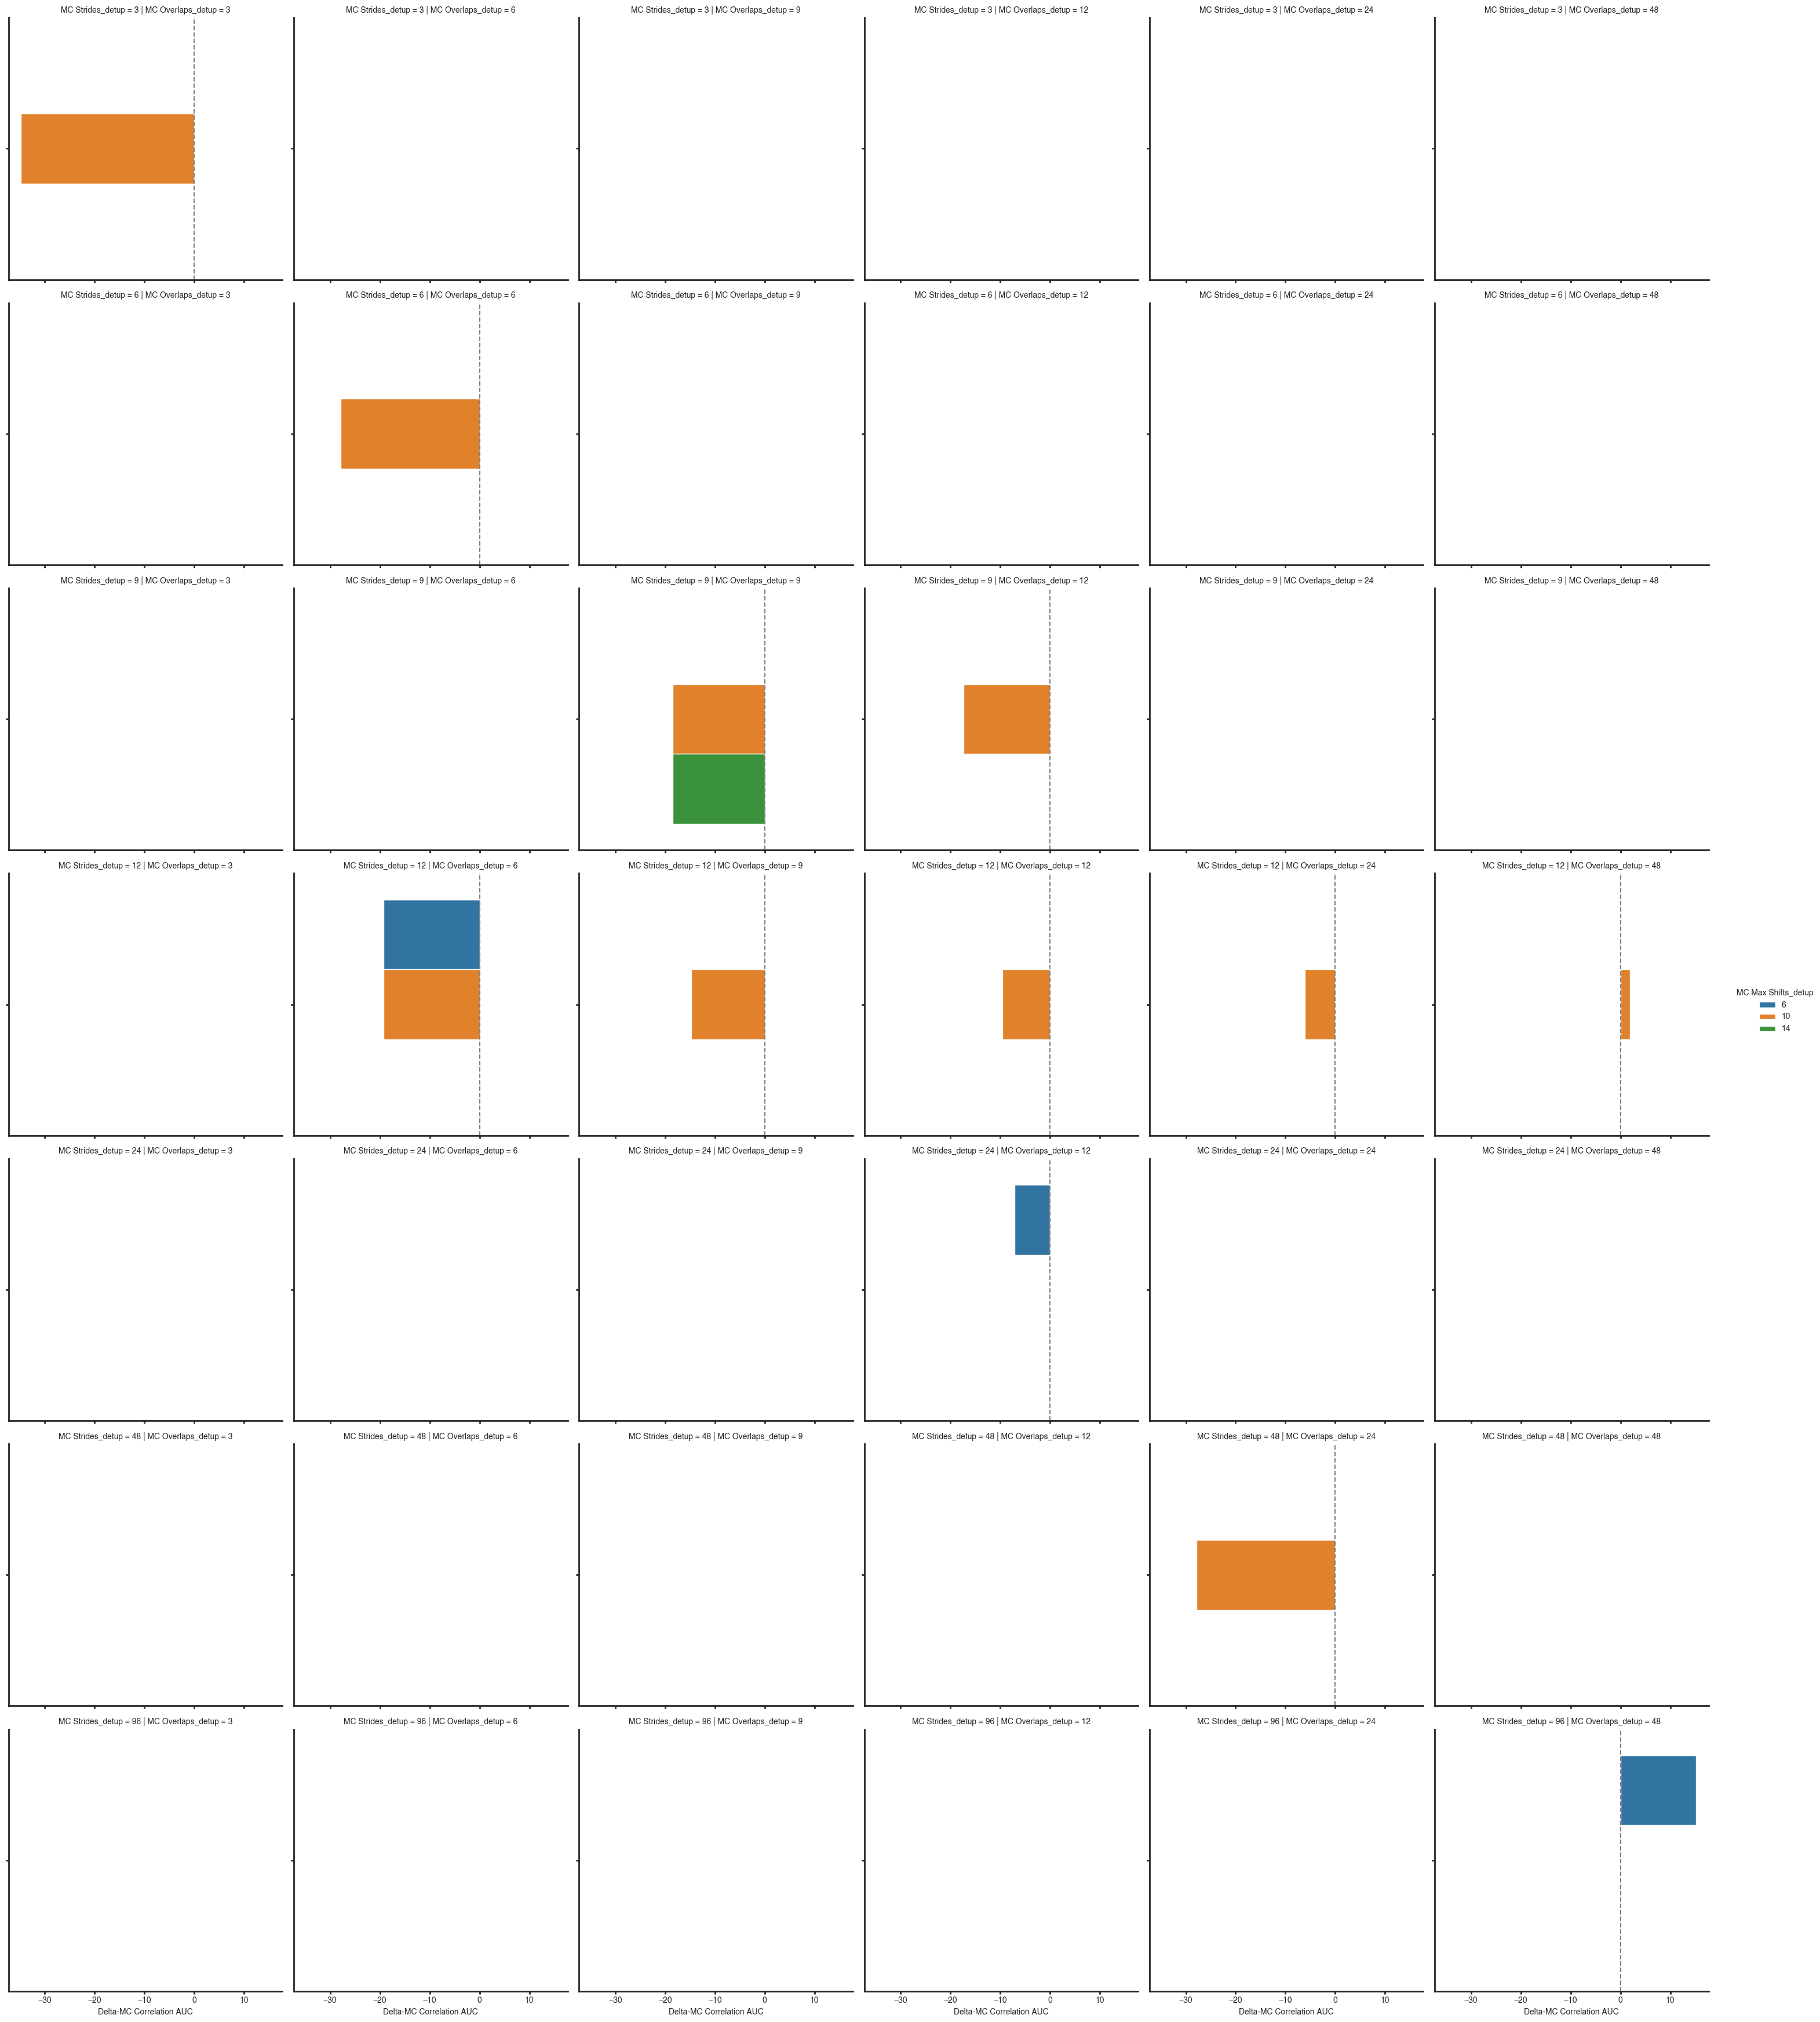

In [35]:
fg = sns.catplot(df2, x='Delta-MC Correlation AUC', row='MC Strides_detup', col='MC Overlaps_detup', hue='MC Max Shifts_detup', kind='bar', errorbar=None)
fg.refline(x=0)

### Motion Correction Metrics


In [20]:
# load fine tuning log; do before each run
ft_log_path = os.path.join(multi_experiment_output_dir,
                               'dataframes',
                               'ft_log_202040607.pkl')
if os.path.exists(ft_log_path):
    log.info('Loading metrics from file "{}"', ft_log_path)
else:
    raise FileNotFoundError(f'File "{ft_log_path}" not found.')

if not os.path.isfile(ft_log_path):
    ft_log = pd.DataFrame(columns=['Experiment ID','Run ID','Fish ID','Z Slice','MC Strides',
                               'MC Overlaps','MC Max Shifts', 'MC Max Shifts Deviation',
                               'Datetime', 'Code Version', 'Pre-MC Correlations with Mean Frame',
                               'Post-MC Correlations with Mean Frame', 'Pre-MC Correlation AUC',
                               'Post-MC Correlation AUC', 'Pre-MC Mean Crispness', 'Post-MC Mean Crispness',
                               'Pre-MC ROC', 'Post-MC ROC', 'Execution Time (s)']) # ROC = residual optical flow
    ft_log.to_pickle(ft_log_path)
else:
    ft_log = pd.read_pickle(ft_log_path)

local-nb_cs-ii-[29,33,34]_caiman-motion-correct-sandbox (   6): INFO : Loading metrics from file "E:\andyphung\zf_correlative_microscopy\analyzed_and_generated_data\motion-correction-sandbox\outputs\dataframes\ft_log_202040607.pkl"


In [ ]:
# misc values we need
bord_px_els = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                 np.max(np.abs(mc.y_shifts_els)))).astype(int)
final_size = np.subtract(mc.total_template_els.shape, 2 * bord_px_els) # remove pixels in the boundaries
winsize = 100
swap_dim = False
resize_fact_flow = .2    # downsample for computing ROF

In [ ]:
# for pre and post motion correction tiffs, computes pixel-wise similarity between
# mean image and each frame (correlations), crispness of mean image before and
# after registration (crispness), and residual optical flow (flows)

# see NoRMCorre paper for details


tmpl_orig, correlations_orig, flows_orig, norms_orig, crispness_orig = cm.motion_correction.compute_metrics_motion_correction(
    process_file_names[0], final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_els, correlations_els, flows_els, norms_els, crispness_els = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_els[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

In [ ]:
# plot correlation with mean frame for each dataset

plt.figure(figsize = (20,10))
plt.subplot(211); plt.plot(correlations_orig); plt.plot(correlations_els)
plt.legend(['Original', 'PW-Rigid'])
# plt.subplot(223); plt.scatter(correlations_orig, correlations_rig); plt.xlabel('Original');
# plt.ylabel('Rigid'); plt.plot([0.3,0.7],[0.3,0.7],'r--')
# axes = plt.gca(); axes.set_xlim([0.3,0.7]); axes.set_ylim([0.3,0.7]); plt.axis('square');
plt.subplot(224); plt.scatter(correlations_orig, correlations_els); plt.xlabel('Original');
plt.ylabel('PW-Rigid'); plt.plot([0.3,0.7],[0.3,0.7],'r--')
axes = plt.gca(); axes.set_xlim([0.3,0.7]); axes.set_ylim([0.3,0.7]); plt.axis('square');

In [ ]:
# correlation auc for before and after mc
# lower is better?
auc_c_before = sum([(c - max(correlations_orig)) * -1 for c in correlations_orig])
auc_c_after = sum([(c - max(correlations_els)) * -1 for c in correlations_els])
print(f'auc before: {auc_c_before}')
print(f'auc after: {auc_c_after}')

In [ ]:
# auc plot
plt.figure(figsize = (20,10))
plt.subplot(211); plt.plot([(c - max(correlations_orig)) * -1 for c in correlations_orig]); plt.plot([(c - max(correlations_els)) * -1 for c in correlations_els])
plt.legend(['Original', 'PW-Rigid'])

In [ ]:
# print crispness values
# higher is better
print('Crispness original: ' + str(int(crispness_orig)))
print('Crispness elastic: ' + str(int(crispness_els)))

In [ ]:
fls = [cm.paths.fname_derived_presuffix(mc.fname_tot_els[0], 'metrics', swapsuffix='npz'),
       cm.paths.fname_derived_presuffix(mc.fname[0], 'metrics', swapsuffix='npz'),
       ]

plt.figure(figsize=(20, 10))
for cnt, fl, metr in zip(range(len(fls)), fls, ['pw_rigid', 'raw']):
    with np.load(fl) as ld:
        print(type(ld))
        print("keys", ld.keys())
        print(fl)
        print(str(np.mean(ld['norms'])) + '+/-' + str(np.std(ld['norms'])) +
              ' ; ' + str(ld['smoothness']) + ' ; ' + str(ld['smoothness_corr']))

        plt.subplot(len(fls), 3, 1 + 3 * cnt)
        plt.ylabel(metr)
        print(f"Loading data with base {fl[:-12]}")
        try:
            mean_img = np.mean(
                cm.load(fl[:-12] + '.mmap'), 0)[12:-12, 12:-12]
        except:
            try:
                mean_img = np.mean(
                    cm.load(fl[:-12] + '.tif'), 0)[12:-12, 12:-12]
            except:
                mean_img = np.mean(
                    cm.load(fl[:-12] + 'hdf5'), 0)[12:-12, 12:-12]

        lq, hq = np.nanpercentile(mean_img, [.5, 99.5])
        plt.imshow(mean_img, vmin=lq, vmax=hq)
        plt.title('Mean')
        plt.subplot(len(fls), 3, 3 * cnt + 2)
        plt.imshow(ld['img_corr'], vmin=0, vmax=.35)
        plt.title('Corr image')
        plt.subplot(len(fls), 3, 3 * cnt + 3)
        flows = ld['flows']
        print(type(flows), type(flows_orig), flows.shape)
        plt.imshow(np.mean(
            np.sqrt(flows[:, :, :, 0] ** 2 + flows[:, :, :, 1] ** 2), 0), vmin=0, vmax=0.3)
        plt.colorbar()
        plt.title('Mean optical flow');

In [ ]:
plt.imshow(np.mean(
            np.sqrt(np.array(flows_orig)[:, :, :, 0] ** 2 + np.array(flows_orig)[:, :, :, 1] ** 2), 0), vmin=0, vmax=0.3)
plt.colorbar()
plt.title("Pre-MC mean optical flow")
plt.show()

In [ ]:
print(np.array(flows_orig).shape)

In [ ]:
# log fine tuning results

ft_results = [metadata_dict['experiment_id'], metadata_dict['run_id'], metadata_dict['fish_id'],
              18, strides, overlaps, max_shifts, max_deviation_rigid, datetime.datetime.now().strftime("%m/%d/%Y, %I:%M %p"),
              1, correlations_orig, correlations_els, auc_c_before, auc_c_after, int(crispness_orig), int(crispness_els),
              flows_orig, flows_els, execution_time]
ft_log.loc[0 if pd.isnull(ft_log.index.max()) else ft_log.index.max() + 1] = ft_results
ft_log.to_pickle(ft_log_path)

In [37]:
ft_log[['Experiment ID','Run ID','Fish ID','Z Slice','MC Strides',
                               'MC Overlaps','MC Max Shifts', 'MC Max Shifts Deviation',
                               'Datetime', 'Code Version', 'Pre-MC Correlation AUC',
                               'Post-MC Correlation AUC', 'Pre-MC Mean Crispness', 'Post-MC Mean Crispness', 'Execution Time (s)']]

,Experiment ID,Run ID,Fish ID,Z Slice,MC Strides,MC Overlaps,MC Max Shifts,MC Max Shifts Deviation,Datetime,Code Version,Pre-MC Correlation AUC,Post-MC Correlation AUC,Pre-MC Mean Crispness,Post-MC Mean Crispness,Execution Time (s)
0,cs-ii-29,395,B,18,"(48, 48)","(24, 24)","(6, 6)",3,"06/05/2024, 04:07 PM",1,15.988411,16.001184,100019,104773,-1.000000
1,cs-ii-29,395,B,18,"(24, 24)","(12, 12)","(6, 6)",3,"06/05/2024, 04:48 PM",1,15.988411,14.855147,100019,105682,-1.000000
2,cs-ii-29,395,B,18,"(12, 12)","(6, 6)","(6, 6)",3,"06/05/2024, 05:02 PM",1,15.988411,12.907924,100019,105572,-1.000000
3,cs-ii-29,395,B,18,"(96, 96)","(48, 48)","(6, 6)",3,"06/06/2024, 11:09 AM",1,15.988411,18.414703,100019,104272,-1.000000
4,cs-ii-29,395,B,18,"(12, 12)","(6, 6)","(10, 10)",3,"06/06/2024, 11:16 AM",1,15.988411,12.907924,100019,105572,-1.000000
5,cs-ii-29,395,B,18,"(12, 12)","(12, 12)","(10, 10)",3,"06/06/2024, 11:22 AM",1,15.988411,13.865686,100019,105929,-1.000000
6,cs-ii-29,395,B,18,"(12, 12)","(24, 24)","(10, 10)",3,"06/06/2024, 11:36 AM",1,15.988411,15.005674,100019,106049,-1.000000
7,cs-ii-29,395,B,18,"(12, 12)","(48, 48)","(10, 10)",3,"06/06/2024, 11:42 AM",1,15.988411,16.296539,100019,105832,-1.000000
8,cs-ii-29,395,B,18,"(12, 12)","(12, 12)","(10, 10)",3,"06/06/2024, 11:55 AM",1,15.988411,13.865686,100019,105929,153.521329
9,cs-ii-29,395,B,18,"(12, 12)","(12, 12)","(10, 10)",6,"06/06/2024, 12:00 PM",1,16.101075,13.992300,100011,105897,154.112240


In [ ]:
for index, row in ft_log.iterrows():
    plt.figure(figsize = (20, 20))
    plt.subplot(221); plt.plot(row['Pre-MC Correlations with Mean Frame']); plt.plot(row['Post-MC Correlations with Mean Frame'])
    plt.title("Correlations with mean frame")
    plt.xlabel("Frame Number")
    plt.ylabel("Pearson's correlation coefficient r")
    plt.legend([f"Pre-MC AUC: {round(row['Pre-MC Correlation AUC'], 2)}", f"Post-MC AUC: {round(row['Post-MC Correlation AUC'], 2)}"])
    plt.subplot(222); plt.bar(['Pre-MC Mean Crispness', 'Post-MC Mean Crispness'], [row['Pre-MC Mean Crispness'], row['Post-MC Mean Crispness']], color=['#586F7C', '#7C9FA5'], label=['one', 'two'])
    plt.title("Mean crispness")
    plt.subplot(223); plt.imshow(np.mean(
    np.sqrt(np.array(row['Pre-MC ROC'])[:, :, :, 0] ** 2 + np.array(row['Pre-MC ROC'])[:, :, :, 1] ** 2), 0), vmin=0, vmax=0.3)
    plt.colorbar()
    plt.title("Pre-MC mean optical flow")
    plt.subplot(224); plt.imshow(np.mean(
    np.sqrt(np.array(row['Post-MC ROC'])[:, :, :, 0] ** 2 + np.array(row['Post-MC ROC'])[:, :, :, 1] ** 2), 0), vmin=0, vmax=0.3)
    plt.colorbar()
    plt.title("Post-MC mean optical flow")
    plt.suptitle(f"{row['Experiment ID']}, run {row['Run ID']}, fish {row['Fish ID']}, z={row['Z Slice']}\n {row['Datetime']}, executed in {round(row['Execution Time (s)'])}s\n MC strides: {row['MC Strides']}\n MC overlaps: {row['MC Overlaps']}\n MC max shifts: {row['MC Max Shifts']}\n MC max shifts deviation: {row['MC Max Shifts Deviation']}")
    plt.savefig(os.path.join(multi_experiment_output_dir, "mc_fine_tuning", f"{index}.png"))

In [ ]:
ft_log.to_pickle(ft_log_path)

In [ ]:
print(multi_experiment_output_dir)

### Perform Memory Mapping

In [ ]:
##%% MEMORY MAPPING
# memory map the file in order 'C'
fname_new = cm.save_memmap(mc.mmap_file, base_name='memmap_', order='C',
                           border_to_0=border_to_0, dview=dview) # exclude borders

# now load the file
Yr, dims, T = cm.load_memmap(fname_new)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 
    #load frames in python format (T x X x Y)

In [ ]:
##%% restart cluster to clean up memory
cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='multiprocessing', n_processes=None, single_thread=False)

### Run CNMF

In [ ]:
cnm = cnmf.CNMF(n_processes, params=opts, dview=dview)
cnm = cnm.fit(images)

### Inspect Results

In [ ]:
Cn = cm.local_correlations(images.transpose(1,2,0))
Cn[np.isnan(Cn)] = 0
cnm.estimates.plot_contours_nb(img=Cn)

In [ ]:
%%capture
##%% RE-RUN seeded CNMF on accepted patches to refine and perform deconvolution 
cnm2 = cnm.refit(images, dview=dview)

### Component Evaluation

In [ ]:
##%% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier

cnm2.estimates.evaluate_components(images, cnm2.params, dview=dview)

### Saving CNMF Result

In [ ]:
save_results = True

save_path = os.path.join(
        repo_dir, 'data', 'cnmf_results', 'test_cnmf_results.hdf5')
csutils.touchdir(os.path.dirname(save_path))

if save_results:    
    cnm2.estimates.Cn = Cn
    cnm2.save(save_path)

### Load CNMF Results

In [ ]:
load_results = True

save_path = os.path.join(
        repo_dir, 'data', 'cnmf_results', 'test_cnmf_results.hdf5')

if load_results:
    if 'dview' not in locals():
        c, dview, n_processes = cm.cluster.setup_cluster(
            backend='multiprocessing', 
            n_processes=None, 
            single_thread=False)
    
    cnmf_load = cnmf.load_CNMF(
        save_path,
        n_processes=n_processes,
        dview=dview)
    log.info('Sucessfully loaded CNMF results from\n\t"{}"', save_path)
else:
    cnmf_load = cnm2
    cnmf_load.estimates.Cn = Cn

In [ ]:
##%% PLOT COMPONENTS
cnmf_load.estimates.plot_contours_nb(
    img=cnmf_load.estimates.Cn, 
    idx=cnmf_load.estimates.idx_components)

In [ ]:
# accepted components
cnmf_load.estimates.nb_view_components(
    img=cnmf_load.estimates.Cn,
    idx=cnmf_load.estimates.idx_components)

In [ ]:
if len(cnmf_load.estimates.idx_components_bad) > 0:
    cnmf_load.estimates.nb_view_components(
        img=cnmf_load.estimates.Cn, 
        idx=cnmf_load.estimates.idx_components_bad)
else:
    print("No components were rejected.")

### DF/F Value Extraction

In [ ]:
cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='multiprocessing', n_processes=None, single_thread=False)

In [ ]:
##%% Extract DF/F values
if cnmf_load.estimates.F_dff is None:
    cnmf_load.estimates.detrend_df_f(
        quantileMin=8, 
        frames_window=250,
        use_residuals=False)
else:
    log.info('DF/F already computed.')

In [ ]:
cnmf_load.estimates.select_components(use_object=True)

In [ ]:
cnmf_load.estimates.nb_view_components(
    img=cnmf_load.estimates.Cn,
    denoised_color='red')
log.info('You may need to change the data rate to generate this one:'
         ' use jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10'
         ' before opening jupyter notebook')